In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
#import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

sys.path.insert(1, os.path.join(sys.path[0], '..'))

from SEIR.utils import config

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m')

max_files = 100

print(f">>> Sampling {max_files} simulations...")


folder = [x for x in Path('model_output/hosp').glob('*') if not x.is_file()]
#folder = [x[0] for x in os.walk('model_output/hosp')]


all_hosp_sim = {}

for fold in folder:
    if ('importation' not in str(fold)):
        data = []
        print(f'Exploring {str(fold)[:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            if files_loaded < max_files:
                sim = pd.read_csv(filename)
                sim = sim.groupby('time').sum()
                sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid'

                data.append(sim)
                files_loaded += 1
        for filename in Path(str(fold)).rglob('*.parquet'):
            if files_loaded < max_files:
                sim = pq.read_table(filename).to_pandas()
                sim = sim.groupby('time').sum()
                #sim.drop(['geo_ind', 'date_inds'], axis =1, inplace=True)  # 'geoid' 'sim_num', 'sim_num_good',
                data.append(sim)
                files_loaded += 1

        if (len(data) > 0): 
            print(f'... {len(data)} loaded')
            all_hosp_sim[str(fold)[:]] = data

try:
    config.set_file(config_file)
    dates = config["report"]["formatting"]["display_dates"].get()
    print('loaded config sucessfuly')
except:
    dates = []
    dates.append(str(sim.index[-1]))
    print('Failed to load config, using only endate')



varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD']

fig, axes = plt.subplots(len(varplot),len(all_hosp_sim), figsize =(23,20), sharex=True)
for vi, var in enumerate(varplot):
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        if len(all_hosp_sim) > 1:
            ax = axes[vi][scn]
        else:
            ax = axes[vi]
        ax.set_title(key)
        #ax.xaxis.set_major_locator(plt.MaxNLocator(12))
        #ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.grid()
        ax.set_ylabel(var)
        for sim in all_hosp_sim[key]:
            ax.plot(sim[var])
    fig.autofmt_xdate()
plt.show()

fig, axes = plt.subplots(len(varplot)//2,2, figsize =(15,15), sharex=True)
for vi, var in enumerate(varplot):
    ax = axes.flat[vi]
    ax.set_title(var)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid()
    ax.set_ylabel(var)
    for scn, key in enumerate(list(all_hosp_sim.keys())):
        sim_of_var = []
        for sim in all_hosp_sim[key]:
            temp = sim[var]
            sim_of_var.append(temp)
        temp = pd.concat(sim_of_var,axis=1)

        ax.plot(temp.quantile(.5, axis = 1), label = key,linewidth = 2)
        ax.fill_between(temp.index, temp.quantile(.05, axis = 1), 
                      temp.quantile(.95, axis = 1), alpha =.1)
        ax.legend()

    fig.autofmt_xdate()
plt.show()
#fig, axes = plt.subplots(len(varplot),1, figsize =(15,15))
#
#for i, var in enumerate(varplot):
#    ax = axes.flat[i]
#    # hide axes
#    fig.patch.set_visible(False)
#    ax.axis('off')
#    ax.axis('tight')
#    ax.set_title(f'Median of MAX of {var} until date')
#    col = list(all_hosp_sim.keys())
#    col.insert(0, 'dates')
#    df = pd.DataFrame(0, columns=col, index = dates)
#    df['dates'] = dates
#    for scn, key in enumerate(list(all_hosp_sim.keys())):
#        sim_of_var = []
#        for sim in all_hosp_sim[key]:
#            temp = sim[var]
#            sim_of_var.append(temp)
#        temp = pd.concat(sim_of_var,axis=1)
#        
#        for j, d in enumerate(dates):
#            df.iloc[j,scn+1] = int(temp[:datetime.datetime.strptime(d, '%Y-%m-%d').date()].max().quantile(.5))
#            
#    print(df)
#    print('ok')
#    ax.table(cellText=df.values, colLabels=df.columns, loc='center')
#
#fig.tight_layout()
#pdf.savefig(fig)

print('Done ploot')

folder = [x for x in Path('model_output/seir').glob('*') if not x.is_file()]

all_seir_sim_cumI = {}
all_seir_sim_diffI = {}

for fold in folder:
    if ('importation' not in str(fold)):
        data_cumI = []
        data_diffI = []
        print(f'loading {str(fold)[:]} ... ', end = '')
        files_loaded = 0
        for filename in Path(str(fold)).rglob('*.csv'):
            if files_loaded < max_files:
                sim = pd.read_csv(filename)
                sim_c = sim[sim['comp']=='cumI']
                sim_c.drop('comp', axis =1, inplace=True)
                sim_c.set_index('time', inplace = True)
                sim_c = sim_c.sum(axis = 1)

                sim_d = sim[sim['comp']=='diffI']
                sim_d.drop('comp', axis =1, inplace=True)
                sim_d.set_index('time', inplace = True)
                sim_d = sim_d.sum(axis = 1)

                data_cumI.append(sim_c)
                data_diffI.append(sim_d)
                files_loaded += 1

        for filename in Path(str(fold)).rglob('*.parquet'):
            if files_loaded < max_files:
                sim = pq.read_table(filename).to_pandas()
                sim_c = sim[sim['comp']=='cumI']
                sim_c.drop('comp', axis =1, inplace=True)
                sim_c.set_index('time', inplace = True)
                sim_c = sim_c.sum(axis = 1)

                sim_d = sim[sim['comp']=='diffI']
                sim_d.drop('comp', axis =1, inplace=True)
                sim_d.set_index('time', inplace = True)
                sim_d = sim_d.sum(axis = 1)

                data_cumI.append(sim_c)
                data_diffI.append(sim_d)
                files_loaded += 1

        data_cumI = pd.concat(data_cumI,axis=1)
        if (len(data_cumI.columns)>0):
            print(f'... {len(data_cumI.columns)} loaded')
            data_diffI = pd.concat(data_diffI,axis=1)
            all_seir_sim_cumI[str(fold)[:]] = data_cumI
            all_seir_sim_diffI[str(fold)[:]] = data_diffI


fig, axes = plt.subplots(2,1, figsize =(12,12), sharex=True)


for key, value in all_seir_sim_cumI.items():
    axes[0].plot(value, linewidth = .3)
    axes[0].plot(value.quantile(.5, axis = 1), label = key, linewidth = 2)
    axes[0].fill_between(value.index, value.quantile(.05, axis = 1), 
                      value.quantile(.95, axis = 1), alpha =.1 )


axes[0].legend()
axes[0].grid()
axes[0].set_title(f'cumI accross all node. Median and 95% CI')

for key, value in all_seir_sim_diffI.items():
    axes[1].plot(value, linewidth = .3)
    axes[1].plot(value.quantile(.5, axis = 1), label = key, linewidth = 2)
    axes[1].fill_between(value.index, value.quantile(.05, axis = 1), 
                      value.quantile(.95, axis = 1), alpha =.1 )

axes[1].legend()
axes[1].grid()
axes[1].set_title(f'diffI accross all node. Median and 95% CI')
fig.autofmt_xdate()
plt.show()

fig, axes = plt.subplots(len(all_seir_sim_cumI),1, figsize =(15,15), sharex=True)
i=0
for key, value in all_seir_sim_cumI.items():
    if len(all_seir_sim_cumI) > 1:
        ax = axes.flat[i]
    else:
        ax = axes
    #fig, axes = plt.subplots(1,1, figsize =(10,5))
    ax = value.max().hist(ax= ax)
    ax.set_title(f"Final Size {key}")
    i=i+1

#sim = pq.read_table(filename).to_pandas()
#sim = sim[sim['comp']==comp]
#sim.drop('comp', axis =1, inplace=True)
#sim.set_index('time', inplace = True)
#sim.plot( legend = False)
#all_sim[list(all_sim.keys())[0]][0].plot()
plt.show()

>>> Sampling 100 simulations...
Exploring model_output/hosp/minimal ... ... 100 loaded
Failed to load config, using only endate


<Figure size 2300x2000 with 6 Axes>

<Figure size 1500x1500 with 6 Axes>

Done ploot
loading model_output/seir/minimal ... 

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


... 100 loaded


<Figure size 1200x1200 with 2 Axes>

<Figure size 1500x1500 with 1 Axes>

In [2]:
sim = pq.read_table('test_stoch/000000002.2020.08.20.12:31:46.UTC.hosp_stoch.parquet').to_pandas()
sim=sim[sim['geoid']=='36055']
sim = sim.groupby('time').sum()
sim.head()

,incidI,incidH,hosp_curr,incidD,incidICU,icu_curr,incidVent,vent_curr,incidC
time,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


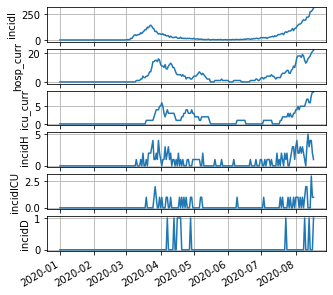

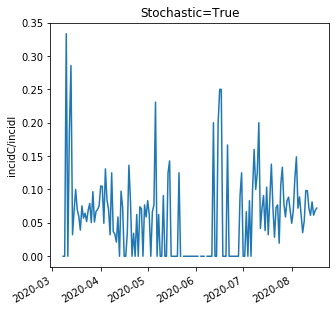

In [250]:
varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD']

fig, axes = plt.subplots(len(varplot),1, figsize =(5,5), sharex=True)
for vi, var in enumerate(varplot):
    #ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    #ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax = axes[vi]
    ax.grid()
    ax.set_ylabel(var)
    ax.plot(sim[var])
    fig.autofmt_xdate()
plt.show()

var_up = 'incidC'
var_down = 'incidI'

fig, axes = plt.subplots(1,1, figsize =(5,5), sharex=True)
axes.plot(sim[var_up]/sim[var_down].shift(7))
axes.set_ylabel(f"{var_up}/{var_down}")
axes.set_title('Stochastic=True')
fig.autofmt_xdate()
plt.show()

In [4]:
#sim = pq.read_table('test_stoch/000000001.2020.08.20.12:44:43.UTC.hosp_notstoch.parquet').to_pandas()
sim = pq.read_table('model_output/hosp/minimal/Scenario1/low/2020.08.26.12:27:19.UTC/global/final/000000001.2020.08.26.12:27:19.UTC.hosp.parquet').to_pandas()
print(len(sim['geoid'].unique()))
geoid = '36055'
# Find geod to import
print(sim[sim['incidH'] == sim['incidH'].max()])
sim=sim[sim['geoid']==geoid]
sim = sim.groupby('time').sum()
sim.head()

62
            time  geoid   incidI       incidH   hosp_curr     incidD  \
12973 2020-04-03  36059  41738.0  1314.762916  8176.31715  31.936901   

         incidICU     icu_curr   incidVent   vent_curr       incidC  
12973  441.520596  2403.271993  180.377969  858.774901  5512.239233  


,incidI,incidH,hosp_curr,incidD,incidICU,icu_curr,incidVent,vent_curr,incidC
time,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


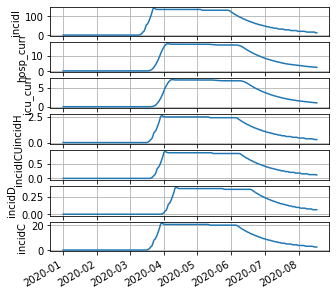

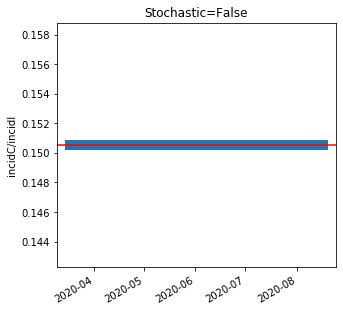

In [9]:
varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD', 'incidC']

fig, axes = plt.subplots(len(varplot),1, figsize =(5,5), sharex=True)
for vi, var in enumerate(varplot):
    #ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    #ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax = axes[vi]
    ax.grid()
    ax.set_ylabel(var)
    ax.plot(sim[var])
    fig.autofmt_xdate()
#plt.show()

hpar = pq.read_table('model_output/hpar/minimal/Scenario1/low/2020.08.26.12:27:19.UTC/global/final/000000001.2020.08.26.12:27:19.UTC.hpar.parquet').to_pandas()

var_up = 'incidC'
var_down = 'incidI'

fig, axes = plt.subplots(1,1, figsize =(5,5), sharex=True)
axes.plot(sim[var_up]/sim[var_down].shift(7), lw =10)
axes.set_ylabel(f"{var_up}/{var_down}")
axes.axhline(float(hpar[(hpar['geoid'] ==geoid) & (hpar['outcome'] == var_up)].value), color ='r')
axes.set_title('Stochastic=False')
fig.autofmt_xdate()
plt.show()

In [113]:
1000*0.095495

95.49499999999999

In [165]:
# load correstponding hpar
#hpar[(hpar['geoid'] == '36055') & (hpar['outcome'] == 'incidC')].value
hpar[(hpar['geoid'] == geoid)]

,geoid,quantity,outcome,source,value
27,36055,probability,incidH,incidI,0.018233
89,36055,probability,incidICU,incidH,0.353233
151,36055,probability,incidVent,incidICU,0.438103
213,36055,probability,incidD,incidI,0.002674
275,36055,probability,incidC,incidI,0.095495


### Whole progress to see what's wrong

In [9]:
branching_data = pq.read_table('model_output/hpar/minimal/Scenario1/low/2020.08.20.12:44:43.UTC/global/final/000000001.2020.08.20.12:44:43.UTC.hpar.parquet').to_pandas()
hpar = pq.read_table('model_output/hpar/minimal/Scenario1/low/2020.08.20.12:44:43.UTC/global/final/000000001.2020.08.20.12:44:43.UTC.hpar.parquet').to_pandas()
branching_data["colname"] = "R" + branching_data["outcome"] + "|" + branching_data["source"]
branching_data = branching_data[["geoid","colname","value"]]
branching_data = pd.pivot(branching_data, index="geoid",columns="colname",values="value")

OSError: Passed non-file path: model_output/hpar/minimal/Scenario1/low/2020.08.20.12:44:43.UTC/global/final/000000001.2020.08.20.12:44:43.UTC.hpar.parquet

In [239]:
probI2C = branching_data['RincidC|incidI'].to_numpy()

In [4]:
from Outcomes import outcomes
in_run_id = '2020.08.21.16:22:58.UTC'
in_prefix='minimal/Scenario1/low/2020.08.21.16:22:58.UTC/global/final/'
sim_id = 1
diffI, places, dates = outcomes.read_seir_sim(in_run_id, in_prefix, sim_id)

In [5]:
incidI = diffI.drop(['time'], axis=1).to_numpy().astype(np.int32)

In [7]:
incidC = np.round(incidI *  (probI2C * np.ones_like(incidI)))
idx = list(places).index(geoid)

NameError: name 'probI2C' is not defined

In [8]:
plt.plot(incidC/incidI);

NameError: name 'incidC' is not defined

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


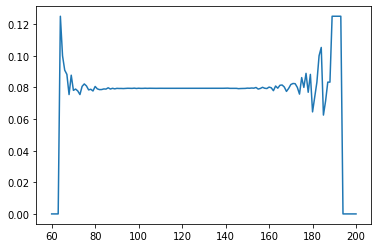

In [244]:
plt.plot(incidC[:,idx]/incidI[:, idx])

In [245]:
(probI2C*np.ones_like(incidI))[:,idx]

array([0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942119,
       0.07942119, 0.07942119, 0.07942119, 0.07942119, 0.07942

In [246]:
probI2C[idx]

0.07942119405648893

In [247]:
hpar[(hpar['geoid'] == geoid)]

,geoid,quantity,outcome,source,value
27,36055,probability,incidH,incidI,0.018233
89,36055,probability,incidICU,incidH,0.353233
151,36055,probability,incidVent,incidICU,0.438103
213,36055,probability,incidD,incidI,0.002674
275,36055,probability,incidC,incidI,0.079421


Something is wrong above.... the hpar value changes

In [201]:
branching_data = pq.read_table('model_output/hpar/minimal/Scenario1/low/2020.08.20.12:44:43.UTC/global/final/000000001.2020.08.20.12:44:43.UTC.hpar.parquet').to_pandas()
hpar =           pq.read_table('model_output/hpar/minimal/Scenario1/low/2020.08.20.12:44:43.UTC/global/final/000000001.2020.08.20.12:44:43.UTC.hpar.parquet').to_pandas()
branching_data.head()

,geoid,quantity,outcome,source,value
0,36001,probability,incidH,incidI,0.018450
1,36003,probability,incidH,incidI,0.018522
2,36005,probability,incidH,incidI,0.015359
3,36007,probability,incidH,incidI,0.019659
4,36009,probability,incidH,incidI,0.019218


In [202]:
branching_data["colname"] = "R" + branching_data["outcome"] + "|" + branching_data["source"]
branching_data[branching_data['geoid'] == geoid]

,geoid,quantity,outcome,source,value,colname
27,36055,probability,incidH,incidI,0.018233,RincidH|incidI
89,36055,probability,incidICU,incidH,0.353233,RincidICU|incidH
151,36055,probability,incidVent,incidICU,0.438103,RincidVent|incidICU
213,36055,probability,incidD,incidI,0.002674,RincidD|incidI
275,36055,probability,incidC,incidI,0.079421,RincidC|incidI


In [203]:
branching_data = branching_data[["geoid","colname","value"]]
branching_data[branching_data['geoid'] == geoid]

,geoid,colname,value
27,36055,RincidH|incidI,0.018233
89,36055,RincidICU|incidH,0.353233
151,36055,RincidVent|incidICU,0.438103
213,36055,RincidD|incidI,0.002674
275,36055,RincidC|incidI,0.079421


In [204]:
branching_data = pd.pivot(branching_data, index="geoid",columns="colname",values="value")

In [207]:
branching_data.loc[geoid]

colname
RincidC|incidI         0.079421
RincidD|incidI         0.002674
RincidH|incidI         0.018233
RincidICU|incidH       0.353233
RincidVent|incidICU    0.438103
Name: 36055, dtype: float64

So it's ok with transformation of the hpar in branching data: it gives the right thing

In [222]:
branching_data[(branching_data['RincidC|incidI'] < 0.1073) & (branching_data['RincidC|incidI'] > 0.1071)]

colname,RincidC|incidI,RincidD|incidI,RincidH|incidI,RincidICU|incidH,RincidVent|incidICU
geoid,,,,,
36065,0.10722,0.003035,0.019722,0.371214,0.438735
36107,0.10721,0.002914,0.019551,0.350917,0.438000


So something is off, it's shifting to another thing

In [212]:
places

Index(['36041', '36097', '36123', '36049', '36095', '36099', '36031', '36121',
       '36073', '36025', '36003', '36039', '36023', '36057', '36017', '36107',
       '36033', '36035', '36037', '36077', '36115', '36021', '36043', '36051',
       '36113', '36053', '36105', '36011', '36009', '36019', '36015', '36117',
       '36101', '36079', '36109', '36069', '36089', '36045', '36075', '36013',
       '36093', '36083', '36111', '36007', '36063', '36091', '36065', '36027',
       '36001', '36087', '36071', '36085', '36067', '36055', '36029', '36119',
       '36059', '36005', '36103', '36061', '36081', '36047'],
      dtype='object')

colname,RincidC|incidI,RincidD|incidI,RincidH|incidI,RincidICU|incidH,RincidVent|incidICU
36041,0.120045,0.004110,0.025361,0.377698,0.438061
36097,0.180480,0.003021,0.020160,0.353781,0.437512
36123,0.110075,0.003050,0.019567,0.373803,0.437417
36049,0.091781,0.002824,0.018895,0.353607,0.438420
36095,0.071393,0.002991,0.019790,0.356149,0.437431
...,...,...,...,...,...
36005,0.054467,0.002075,0.015359,0.320742,0.438279
36103,0.083899,0.002564,0.018003,0.337492,0.437501
36061,0.070432,0.002518,0.017945,0.337262,0.438075
36081,0.010961,0.002510,0.017745,0.339322,0.437141


In [229]:
diffI.columns

Index(['36041', '36097', '36123', '36049', '36095', '36099', '36031', '36121',
       '36073', '36025', '36003', '36039', '36023', '36057', '36017', '36107',
       '36033', '36035', '36037', '36077', '36115', '36021', '36043', '36051',
       '36113', '36053', '36105', '36011', '36009', '36019', '36015', '36117',
       '36101', '36079', '36109', '36069', '36089', '36045', '36075', '36013',
       '36093', '36083', '36111', '36007', '36063', '36091', '36065', '36027',
       '36001', '36087', '36071', '36085', '36067', '36055', '36029', '36119',
       '36059', '36005', '36103', '36061', '36081', '36047', 'time'],
      dtype='object')

Ok, order is wrong, this is a fix:

In [238]:
branching_data = branching_data.loc[diffI.drop('time', axis=1).columns]

62
            time  geoid   incidI  incidH  hosp_curr  incidD  incidICU  \
13706 2020-05-16  36061  40764.0   915.0     6022.0    60.0     295.0   

       icu_curr  incidVent  vent_curr  incidC  
13706    1986.0      125.0      741.0    24.0  


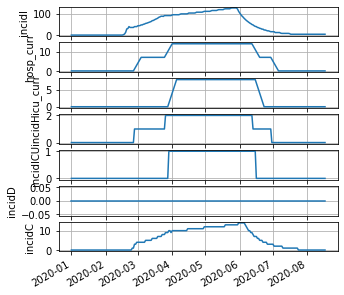

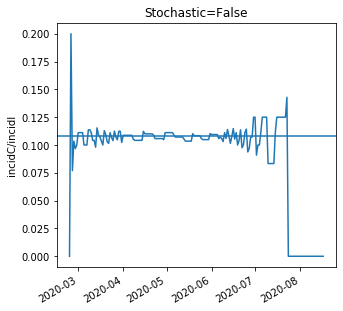

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
#import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
#sim = pq.read_table('test_stoch/000000001.2020.08.20.12:44:43.UTC.hosp_notstoch.parquet').to_pandas()
sim = pq.read_table('model_output/hosp/minimal/Scenario1/low/2020.08.21.16:22:58.UTC/global/final/000000003.2020.08.21.16:22:58.UTC.hosp.parquet').to_pandas()
hpar = pq.read_table('model_output/hpar/minimal/Scenario1/low/2020.08.21.16:22:58.UTC/global/final/000000003.2020.08.21.16:22:58.UTC.hpar.parquet').to_pandas()
print(len(sim['geoid'].unique()))
geoid = '36059'
# Find geod to import
print(sim[sim['incidH'] == sim['incidH'].max()])
sim=sim[sim['geoid']==geoid]
sim = sim.groupby('time').sum()
sim.head()

varplot = ['incidI', 'hosp_curr', 'icu_curr', 'incidH','incidICU', 'incidD', 'incidC']

fig, axes = plt.subplots(len(varplot),1, figsize =(5,5), sharex=True)
for vi, var in enumerate(varplot):
    #ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    #ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax = axes[vi]
    ax.grid()
    ax.set_ylabel(var)
    ax.plot(sim[var])
    fig.autofmt_xdate()
#plt.show()



var_up = 'incidC'
var_down = 'incidI'

fig, axes = plt.subplots(1,1, figsize =(5,5), sharex=True)
axes.plot(sim[var_up]/sim[var_down].shift(7))
axes.set_ylabel(f"{var_up}/{var_down}")
axes.axhline(float(hpar[(hpar['geoid'] ==geoid) & (hpar['outcome'] == var_up)].value))
axes.set_title('Stochastic=False')
fig.autofmt_xdate()
plt.show()

In [39]:
#sim = pq.read_table('test_stoch/000000001.2020.08.20.12:44:43.UTC.hosp_notstoch.parquet').to_pandas()
sim = pq.read_table('model_output/seir/minimal/Scenario1/low/2020.08.28.15:02:18.UTC/global/final/000000001.2020.08.28.15:02:18.UTC.seir.parquet').to_pandas()
sim.index = sim['time']
sim.head()

,comp,36041,36097,36123,36049,36095,36099,36031,36121,36073,...,36055,36029,36119,36059,36005,36103,36061,36081,36047,time
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,S,4908.0,18566.0,25250.0,27017.0,32789.0,35309.0,39416.0,42367.0,43169.0,...,741274.0,921202.0,939406.0,1329083.0,1365725.0,1482548.0,1583345.0,2199169.0,2466782.0,2020-01-01
2020-01-01,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
2020-01-01,I1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
2020-01-01,I2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01
2020-01-01,I3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01


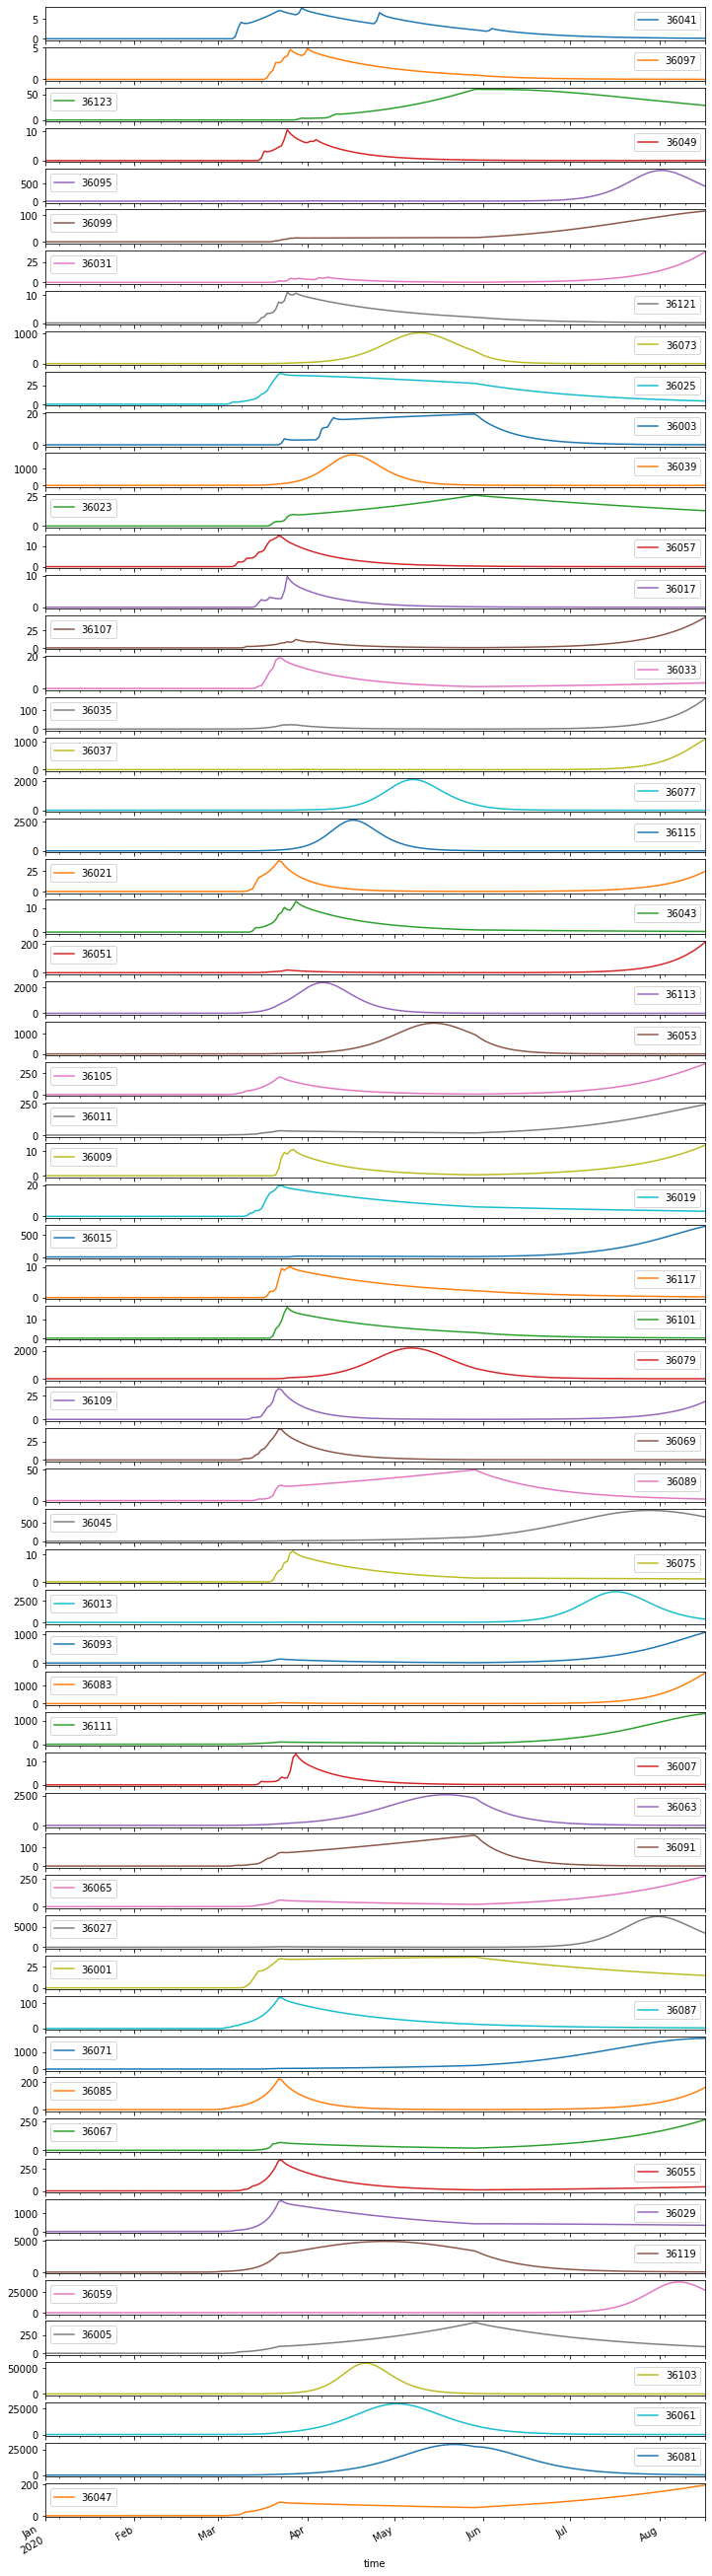

In [40]:
sim[sim['comp']=='diffI'].drop('time', axis=1).plot(subplots=True, figsize=(12,52));